# Men's Olympic 100m winning times
This notebook illustrates the implementation of least squares to find the unknown parameters of a linear regressor given the training data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [2]:
data_folder = '/home/lasdonnas/data/malis/'

In [3]:
#1- Data loading
ds = pd.read_csv(data_folder + 'olympics_100m.csv', sep=',')

#Splitting traing/test
training = ds[0:len(ds)-2]
testing=ds[-2:]

#Let's use the notation from the lecture
X = training.loc[:,'Year'].values
y = training.loc[:, 'Time'].values
X = X.reshape(len(training),1)

In [4]:
#we add the column of ones to X. Check scikit-learn documentation to see how this is achieved
poly = PolynomialFeatures(1)  
X = poly.fit_transform(X)

Now, let's implement a function called least_squares that will compute:

$\mathbf{\hat{w}}=(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{y}$

In [5]:

def least_squares(X,y):
    X_t = np.transpose(X) #X^T
    X_t_X = X_t.dot(X)    #X^TX
    X_inv = inv(X_t_X)    #(#X^TX)^-1
    X_T_y = X_t.dot(y)    #X^Ty
    w = X_inv.dot(X_T_y)
    
    return w


In [6]:
w = least_squares(X,y)
print('Weights: ', w)

Weights:  [ 3.57714562e+01 -1.30037735e-02]


Let's estimate the mean squared error (MSE) and the residual sum-of-squares (RSS):

In [7]:
y_hat = np.sum(X*w,axis=1)

RSS = sum((y - y_hat)*(y - y_hat))
MSE = RSS/len(training)

print('RSS: ', RSS, '\nMSE: ', MSE)

RSS:  1.304203366605223 
MSE:  0.04830382839278604


Now, let's predict the times of 2016 and 2020 

*Note:* Olympics were held in 2021.

In [8]:
X_test = testing.loc[:,'Year'].values
y_test = testing.loc[:, 'Time'].values
X_test = X_test.reshape(len(testing),1)

X_test = poly.fit_transform(X_test)

y_hat_test = np.sum(X_test*w,axis=1)
MSE = sum((y_test - y_hat_test)*(y_test - y_hat_test))/len(testing)

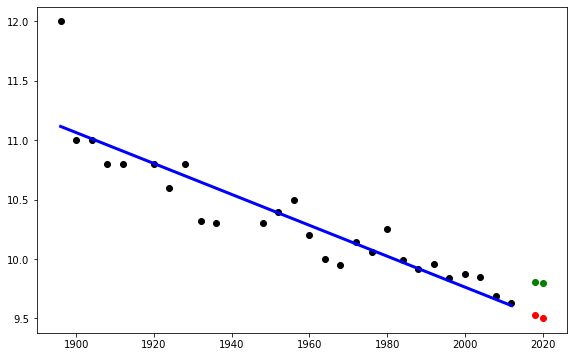

In [9]:
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.scatter(X[:,1], y,  color='black')
plt.plot(X[:,1], y_hat,  color='blue', linewidth=3)
plt.scatter(X_test[:,1], y_hat_test, color='red')
plt.scatter(X_test[:,1], y_test,  color='green')
plt.show()

In [10]:
print('MSE: ', MSE)

MSE:  0.08310170959784373


In [11]:
print('Predicted times [2016, 2020]: ', y_hat_test)
print('Real times [2016, 2020]: ', y_test)

Predicted times [2016, 2020]:  [9.52984123 9.50383369]
Real times [2016, 2020]:  [9.81 9.8 ]


## An alternative solution
The previous solution might not be the best, as it can be computationally unstable.

Here, we illustrate an alternative method and we also estimate $\sigma^2$

In [12]:
#Let's get the data from scratch again to play on the safe side
#Splitting traing/test
X = training.loc[:,'Year'].values
y = training.loc[:, 'Time'].values
X = X.reshape(len(training),1)

poly = PolynomialFeatures(1)  
X = poly.fit_transform(X)

X_test = testing.loc[:,'Year'].values
y_test = testing.loc[:, 'Time'].values
X_test = X_test.reshape(len(testing),1)

In [13]:
from numpy import linalg
def MLE(X, y):
    X_t = np.transpose(X) #X^T
    X_t_X = X_t.dot(X)    #X^TX
    X_T_y = X_t.dot(y)    #X^Ty
    
    #An alternative and more efficient way to compute: using a linear solver to solve the eq Ax = b
    w = linalg.solve(X_t_X, X_T_y)
    
    #Solving for sigma
    y_hat = np.sum(X*w,axis=1)
    error = y - y_hat
    sigma = float(1/len(X)) * (error).dot(error)

    return [w, sigma]

In [14]:
w, sigma = MLE(X,y)
print('Weights: ', w, 'sigma^2:', sigma)

Weights:  [ 3.57714562e+01 -1.30037735e-02] sigma^2: 0.048303828392785984


In [15]:
#Predict
X_test = testing.loc[:,'Year'].values
y_test = testing.loc[:, 'Time'].values
X_test = X_test.reshape(len(testing),1)

X_test = poly.fit_transform(X_test)
y_hat_test = np.sum(X_test*w,axis=1)
print('Predicted [2016, 2020] : ', y_hat_test)

Predicted [2016, 2020] :  [9.52984123 9.50383369]


## Fitting a higher order model
In this example, we are going to use a basis expansion of $\mathbf{X}$ that leads to a polynomial representation of our function. As an example, a polynomial representation of order two will have an extra feature $X_{2}=X_{1}^2$. One of order three will have $X_{2}=X_{1}^2$ and $X_{3}=X_{1}^3$ and so on.

We need to do some manipulation of the input data to obtain the polynomial features.

In [16]:
#let's get the original dataset again
X = training.loc[:,'Year'].values
y = training.loc[:, 'Time'].values
X = X.reshape(len(training),1)

X_test = testing.loc[:,'Year'].values
y_test = testing.loc[:, 'Time'].values
X_test = X_test.reshape(len(testing),1)

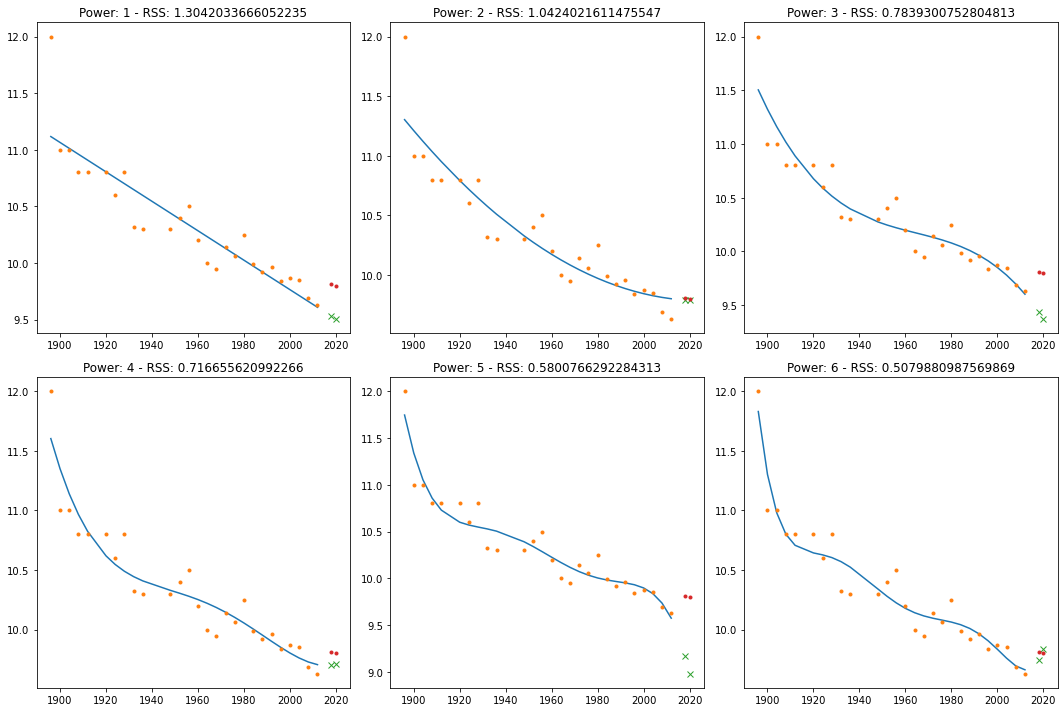

In [17]:
#Thanks to scikit-learn it is quite easy to generate the polynomial features
max_power = 7
from sklearn import datasets, linear_model
plt.rcParams['figure.figsize'] = [15, 10]
for power in range(1,max_power):
    poly = PolynomialFeatures(power)
    X_train = poly.fit_transform(X)
    
    #Feature scaling 
    scaler = StandardScaler(copy=True)
    scaler.fit(X_train[:,1:])
    X_train[:,1:] = scaler.transform(X_train[:,1:])

    #We will use scikit-learn implementation of the linear regressor
    regr = linear_model.LinearRegression(fit_intercept=False) 
    # Train the model using the training set
    regr.fit(X_train, y)
    
    y_hat = regr.predict(X_train)

    #We apply the scaling to the test data using the transform obtained from the training data 
    X_test_poly =  poly.fit_transform(X_test)
    scaled_test = X_test_poly
    X_test_poly[:,1:] = scaler.transform(X_test_poly[:,1:])    
    
    #Predict 2012, 2016    
    y_hat_test = regr.predict(X_test_poly)

    #plotting
    plt.subplot(230+power) #Non-elegant way to assign spaces in the subplot
    plt.tight_layout()
    plt.plot(np.transpose(X[:,0]),y_hat)
    plt.plot(X[:,0],y,'.')
    plt.plot(X_test[:,0],y_hat_test,'x')
    plt.plot(X_test[:,0],y_test,'.')
    plt.title('Power: ' + str(power) + ' - RSS: ' +  str(sum((y - y_hat)*(y - y_hat))))

What can we say about the new models?

<b>Exercise:</b> Compute the MSE for the different models in the test data (2026, 2020). Does this allow you to conclude anything about the models?